<a href="https://colab.research.google.com/github/Guo-bot-1998/Appendicitis/blob/master/Appendicitis_colab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import

In [1]:
!pip install timm
!pip install tqdm
!pip install kora

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.5 MB/s eta 0:00:00


In [2]:
import nibabel as nib
import numpy as np
import os
import pandas as pd
import nibabel as nib
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import random
import re
import json
import timm
import gdown
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
from google.colab import widgets

from tqdm.asyncio import tqdm
from kora.xattr import get_id
import asyncio
import aiohttp
import nest_asyncio
nest_asyncio.apply()
loop = asyncio.get_event_loop()

## 存取

In [3]:
def get_data_disk(driveroot, targetdir):
  """從雲端資料夾targetdir下載檔案到colab root底下同名資料夾
  只下載沒有下載的檔案.

  driveroot為雲端檔案資料夾root"""

  if not os.path.exists('/content/' + targetdir):
    os.makedirs(targetdir)
    print(f"making {targetdir} dir...")

  files_on_drive = os.listdir(driveroot+'/'+targetdir)
  files_in_localdir = os.listdir(f"/content/{targetdir}")
  files_to_download = [f for f in files_on_drive if f not in files_in_localdir]
  files = [(filename, get_id(f'{driveroot}/{targetdir}/{filename}')) for filename in files_to_download]


  for idx, (name, file_id) in enumerate(files):

    if not file_id:
      print(f"未找到文件: {name}")
      continue

    # 下载文件
    request = drive_service.files().get_media(fileId=file_id)
    fh = io.BytesIO()
    downloader = MediaIoBaseDownload(fh, request)

    done = False
    while not done:
      status, done = downloader.next_chunk()
      # print(f"下载 {name} 进度: {int(status.progress() * 100)}%")

    # 将文件内容写入本地文件
    local_file_path = os.path.join('/content', targetdir, name)

    with open(local_file_path, 'wb') as f:
      fh.seek(0)
      f.write(fh.read())

    print(f"{idx+1}/{len(files)}: {name} downloaded")




async def download_file(session, name, file_id, file_path, token):
  if not file_id:
    print(f"未找到文件: {name}")
    return

  download_url = f"https://www.googleapis.com/drive/v3/files/{file_id}?alt=media"
  headers = {"Authorization": f"Bearer {token}"}

  async with session.get(download_url, headers=headers) as response:
    if response.status == 200:
      with open(file_path, 'wb') as f:
        while True:
          chunk = await response.content.read(1024)
          if not chunk:
            break
          f.write(chunk)
      # print(f"Downloaded: {name}...")
    else:
      print(f"Failed: {name}!! status: {response.status}")


# 定义异步获取数据的主函数
async def get_data_disk_async(driveroot, targetdir, token):
  # 生成文件夹的绝对路径
  drive_folder_path = os.path.join(driveroot, targetdir)
  local_folder_path = os.path.join('/content', targetdir)

  if not os.path.exists(local_folder_path):
    os.makedirs(local_folder_path)
    print(f"making {targetdir} dir...")

  # 获取文件列表
  files_on_drive = os.listdir(drive_folder_path)
  files_in_localdir = os.listdir(local_folder_path)
  files_to_download = [f for f in files_on_drive if f not in files_in_localdir]
  files = [(filename, get_id(os.path.join(drive_folder_path, filename))) for filename in files_to_download]

  async with aiohttp.ClientSession() as session:
    tasks = []
    for idx, (name, file_id) in enumerate(files):
      local_file_path = os.path.join(local_folder_path, name)
      task = asyncio.create_task(download_file(session, name, file_id, local_file_path, token))
      tasks.append(task)

    # 使用 tqdm 包装任务列表以显示进度条
    for f in tqdm.as_completed(tasks, total=len(tasks)):
      await f



def process_data2(traindir, shift=0, termi=10, dropFalse=0.85, dropPos=0, files=None):
  """Reading data in "traindir" and process them.
  Taking care of memory efficiency"

  Args:
    shift: 從第幾個開始讀取 (當files給定時無效)
    termi: 讀取幾個 (當files給定時無效)
    dropFalse: 被刪除的有闌尾炎的張數比例
    dropPos: 被刪除的有闌尾炎的張數比例
    files: 要讀取的檔案id，預設是None

  Returns:
    images: 输出的图像数据
    labels: 输出的标签数据
  """

  if not files:
    filelist = os.listdir(traindir)
    filelist = filelist[shift:shift+termi]
  else: filelist = files

  return loading_data(traindir, filelist, dropFalse, dropPos)



def loading_data(traindir, filelist, dropFalse, dropPos)\
 -> tuple[torch.tensor, torch.tensor]:

  print(f"reading {traindir=}...")
  labels_ = read_label(labelpath)

  if labels_.index.name != 'id':
    labels_.set_index('id', inplace=True)

  #裁減過的圖片放在Cropped_[範圍]的資料夾下,用路徑名稱判斷資料使否裁減過
  cropmatch = re.search(r'Cropped', traindir)
  if not cropmatch:
    print("讀取未切片的資料夾")
    xlim, ylim, zlim = [0,512], [0,512], [0,None]
  else:
    #範圍 = xstart-xend_ystart-yend_zstart-zend
    ismatch = re.search(r'(\d+-\d+)_(\d+-\d+)_(\d+-\d+)', traindir)
    if ismatch:
      dimens = ismatch.group(0)
      labelidx = dimens.split('_')
      xlim = [int(idx) for idx in labelidx[0].split('-')]
      ylim = [int(idx) for idx in labelidx[1].split('-')]
      zlim = [int(idx) for idx in labelidx[2].split('-')]
      print(f"{xlim=}\n{ylim=}\n{zlim=}")
      if xlim[0] >= xlim[1] or ylim[0] >= ylim[1] or zlim[0] >= zlim[1]:
        print("切片格式不正确")
        return
    else:
      print("切片格式不正确")
      return



  # preallocated(有無裁減過影響preallocated的大小)
  if not cropmatch:
    selecteds = [labels_.loc[labels_.index.str.startswith(afile.strip('.nii.gz')+'_')] for afile in filelist]
    numcuts = [len(selected) for selected in selecteds]
    numcuts = sum(numcuts)
  else:
    numcuts = (zlim[1]-zlim[0]) * len(filelist)
  images = torch.zeros(numcuts,1, ylim[-1]-ylim[0],xlim[-1]-xlim[0])
  labels = -torch.ones(numcuts)
  nimgs = 0
  nprocess = 0

  for key in filelist:
    file_path = os.path.join(traindir, key)
    key = key.strip('.nii.gz')
    scan  = labels_.loc[labels_.index.str.startswith(key+'_')]
    value = nib.load(file_path).get_fdata()

    label_t = torch.tensor(scan['label'][zlim[0]:zlim[-1]]) #每個scan只拿zlim範圍，不滿60張的拿完
    image_t = torch.from_numpy(value).float().permute(2, 0, 1).unsqueeze(1)

    #有幾筆不是512x512, 剪成512x512
    if (not cropmatch) and (image_t.shape[2] != 512 or image_t.shape[3] != 512):
      image_t = cropping(image_t)

    image_t, label_t = remove_false_images(image_t, label_t, dropFalse)
    image_t, label_t = remove_positive_images(image_t, label_t, dropPos)

    n_new = len(label_t)

    images[nimgs:nimgs+n_new] = image_t
    labels[nimgs:nimgs+n_new] = label_t
    nimgs += len(label_t)
    print(f"Process {nprocess}: {key} finished...")
    nprocess += 1


  #after drop
  counts = count_zero(images)
  images = torch.asarray(images[:len(images)-counts])
  labels = labels[labels != -1]

  return images, labels.float()




def read_test(testdir,shift=0,termi=10):
  """Reading data in "testdir"
  not memory efficient
  Args:
    shift: 從第幾個開始讀取
    termi: 讀取幾個
  Returns:
    images: 输出的图像数据
    scans_info: 每個scan的檔名和切片數(原本nii檔所包含的數量)

  """


  filelist = os.listdir(testdir)
  filelist = filelist[shift:shift+termi]
  scans_info = []

  images = []
  nprocess = 0

  for key in filelist:
    file_path = os.path.join(testdir, key)
    key = key.strip('.nii.gz')
    value = nib.load(file_path).get_fdata()
    scans_info.append((key, value.shape[2]))

    image_t = torch.from_numpy(value).float().permute(2, 0, 1).unsqueeze(1)

    images.append(image_t)
    print(f"{nprocess}: Read test {key} finished...")
    nprocess += 1

  images = torch.cat(images,dim=0)
  print(f"read {len(scans_info)} scans")

  return images, scans_info




def save_model(model, modelname="", dirname="", root=os.path.realpath("/content/drive/MyDrive/AOCR2024/params")):

  if not model:
    print("not given model")
    return

  if not os.path.exists(root):
    print(f"{root} not exists!")
    return

  print(f"model will be saved as {root}/{dirname}/{modelname}")

  if not modelname:
    modelname = input("請輸入模型儲存的檔名:")
  if not dirname:
    dirname = input("請輸入模型儲存的資料夾:")

  filename = f"{root}/{dirname}/{modelname}"

  if not os.path.exists(os.path.dirname(filename)):
    os.mkdir(os.path.dirname(filename))

  if os.path.isfile(filename+'.pth'):
      print(f"{filename}.pth exist.")
  else:  #Adam的方向也要存放
      torch.save({'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()}, f'{filename}.pth')

  return filename



def load_model(_model, opti=None, modelname="", dirname="", root=os.path.realpath("/content/drive/MyDrive/AOCR2024/params")):
  """加載模型參數與優化器，如果沒給優化器，則返回None
   如果沒找到訓練參數, 則返回None
   如果沒給資料夾名稱，則產生input prompt請user輸入
    return model, opti, params, filename
  """
  if not modelname:
    modelname = input("請輸入模型參數檔案名稱:")
  if not dirname:
    dirname = input("請輸入儲存模型的母資料夾名稱:")

  filename = f"{root}/{dirname}/{modelname}"
  checkpoint = torch.load(filename+'.pth')
  _params = None


  print(_model.load_state_dict(checkpoint['model_state_dict']))

  if os.path.isfile(filename+'.json'):
    with open(f'{filename}.json', 'r') as f:
      _params = json.load(f)
  if opti:
    opti.load_state_dict(checkpoint['optimizer_state_dict'])

  return _model,opti,_params, filename






def read_label(excel_path) -> pd.DataFrame:
  """Reads a csv file containing ground-truth.
    The csv file should have two columns: 'id' and 'label'.
  """
  with open(excel_path, 'r') as f:
    df = pd.read_csv(f)
    df.set_index('id', inplace=True)
    return df


def read_split(excel_path):
  with open(excel_path, 'r') as f:
    df = pd.read_csv(f)
    return df

def write_error(logpath, e, nprocess):
  # with open(logpath, 'a') as f:
    # f.write(f"{nprocess:} error occured: {e}\n") ##! may stuck the program!!
  print(f"{nprocess:} error occured: {e}\n")


def read_submission(excel_path) -> pd.DataFrame:
  """Reads a csv file containing submission file.
    The csv file should follow the format given by Kaggle.
  """
  with open(excel_path, 'r') as f:
    df = pd.read_csv(f)
    df.set_index('id', inplace=True)
    return df




## 列印結果

In [4]:
def get_confusion(guess, truth):
  if torch.is_tensor(guess):
    guess = guess.cpu().numpy()
  if torch.is_tensor(truth):
    truth = truth.cpu().numpy()

  right = guess == truth
  wrong = np.logical_not(right)
  TP = np.sum(np.logical_and(right, truth == np.ones(right.shape)))
  TN = np.sum(np.logical_and(right, truth == np.zeros(right.shape)))
  FN = np.sum(np.logical_and(wrong, truth == np.ones(wrong.shape)))
  FP = np.sum(np.logical_and(wrong, truth == np.zeros(wrong.shape)))
  return (TP,FP,FN,TN)


def get_score(TP,FP,FN,TN):
  recall = TP/(TP + FN)
  precision = TP/(TP + FP)
  recall = 0 if np.isnan(recall) else recall.item()
  precision = 0 if np.isnan(precision) else precision.item()
  F1 = 0 if recall + precision == 0 else  (2*recall*precision/(recall+precision))

  return recall, precision, F1


def print_results(prediction, labels_):
  TP,FP,FN,TN = get_confusion(prediction, labels_)
  recall, precision, F1 = get_score(TP,FP,FN,TN)
  print(f"\n\
      真實值\n\
  預  +-----+-----+\n\
  測| TP: {TP}| FP: {FP}|\n\
  值| FN: {FN}| TN: {TN}|\n\
      +-----+-----+ \n")

  print(f"{recall=}\n{precision=}\n{F1=}\n")

def create_tab(tabnames):
  tb = widgets.TabBar(tabnames)
  return tb


def display_train(train_info, predict_info_valid, predict_info_train):
  t_loss, t_accu, v_loss, v_accu = train_info
  predict_list_v, labels_v = predict_info_valid
  TP_v,FP_v,FN_v,TN_v = get_confusion(predict_list_v, labels_v)
  recall_v, precision_v, F1_v = get_score(TP_v,FP_v,FN_v,TN_v)

  predict_list_t, labels_t = predict_info_train
  TP_t,FP_t,FN_t,TN_t = get_confusion(predict_list_t, labels_t)
  recall_t, precision_t, F1_t = get_score(TP_t,FP_t,FN_t,TN_t)

  msg = [f"Epoch  train_loss  train_accu   valid_loss  valid_accu",
    f"(valid)recall      precision    F1",
    f"(train)recall      precision    F1"]

  print('-'*len(msg[0]))
  print(msg[0])
  print(f"{epoch:>5d}: {t_loss:<10.8f}  {t_accu:<10.8f}%  {v_loss:<10.8f}  {v_accu:<10.8f}%")
  print(msg[1])
  print(f"       {recall_v:<6.8f}  {precision_v:<11.8f}  {F1_v:<.8f}")
  print(f"       {TP_v=}  {FP_v=}  {FN_v=}  {TN_v=}")
  print(msg[2])
  print(f"       {recall_t:<6.8f}  {precision_t:<11.8f}  {F1_t:<.8f}")
  print(f"       {TP_t=}  {FP_t=}  {FN_t=}  {TN_t=}")
  print('-'*len(msg[0]))

## 數據裁減




In [5]:
def argumenting(images, labels, n=5):
  """
  數據增強。
  在images裡面把所有有闌尾炎的cut複製給定次數，並
  插入回images的隨機位置裡面

  Args:
    images: 输入的图像数据
    labels: 输入的标签数据
    n: 每个样本複製多少次

  Returns:
    增強后的图像数据和标签数据
  """
  where = (labels == True).nonzero(as_tuple=True)[0]
  bad_images = images[where]

  rep_imgs = bad_images.repeat(n, 1, 1, 1)
  rep_labels = torch.ones(rep_imgs.shape[0], dtype=labels.dtype)

  # import pdb
  # pdb.set_trace()
  # 隨機插入argumented圖片
  nimg = images.shape[0]
  rnd_pos = torch.randint(0, nimg, (rep_imgs.shape[0],))
  images = torch.cat((images, rep_imgs), dim=0)
  images = images[torch.argsort(torch.cat((torch.arange(nimg), rnd_pos)))]

  # 對應對置插入標籤
  labels = torch.cat((labels, rep_labels), dim=0)
  labels = labels[torch.argsort(torch.cat((torch.arange(nimg), rnd_pos)))]

  return images, labels

def remove_false_images(images, labels, ratio):
    """
    隨機在images裡面移除一定比例的無闌尾炎cut

    Args:
      images: 输入的图像数据
      labels: 输入的标签数据
      ratio: 移除的比例

    Returns:
      移除后的图像数据和标签数据
    """
    # 找出 labels == 0 的索引
    where_false = (labels == 0).nonzero(as_tuple=True)[0]
    mask = torch.ones(len(images), dtype=torch.bool)
    indices_filter = torch.randperm(len(where_false))[:int(len(where_false)*ratio)]
    mask[where_false[indices_filter]] = False
    images = images[mask]
    labels = labels[mask]

    return images, labels

def remove_positive_images(images, labels, ratio):
    # 找出 labels == 1 的索引
    where_positive = (labels == 1).nonzero(as_tuple=True)[0]
    mask = torch.ones(len(images), dtype=torch.bool)
    indices_filter = torch.randperm(len(where_positive))[:int(len(where_positive)*ratio)]
    mask[where_positive[indices_filter]] = False
    images = images[mask]
    labels = labels[mask]

    return images, labels


def k_fold_split_indices(num_samples, k=5,shuffle_=True):
  """返回geneartor for index. 省記憶體"""
  state_ = None
  if shuffle_:
    state_ = 42
  kf = KFold(n_splits=k, shuffle=shuffle_, random_state=state_)
  return ((train_index, test_index) for train_index, test_index in kf.split(range(num_samples)))


splitpath = r"/content/drive/MyDrive/AOCR2024/TrainValid_split.csv"
def get_split(splitpath=splitpath):
  dfsplit = read_split(splitpath)
  train_ids,valid_ids = (dfsplit[dfsplit['group']=='Train'])['id'].tolist(),(dfsplit[dfsplit['group']=='Valid'])['id'].tolist()
  train_ids,valid_ids = [train_id +'.nii.gz' for train_id in train_ids], [valid_id +'.nii.gz' for valid_id in valid_ids]
  return train_ids,valid_ids

## 數據處理

## 其他

In [6]:

def count_zero(images):
  count = 0
  for image in images:
    if not torch.any(image):
      count += 1
  return count

def cropping(image):
  if image.shape[2] != 512:
    start = (image.shape[2] - 512) // 2
    end = start + 512
    image = image[:, :, start:end, :]

  if image.shape[3] != 512:
    start = (image.shape[3] - 512) // 2
    end = start + 512
    image = image[:, :, :, start:end]
  return image




def custom_sort_key(val):
    parts = val.split('_')
    if len(parts) == 2 and parts[1].isdigit():
        return (parts[0], int(parts[1]))
    return (parts[0], -1)  # 使沒有_(數字)的id排最前面


def isgpu():
    """檢查是否有 CUDA 支持的 GPU"""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("GPU is available")
    else:
        device = torch.device("cpu")
        # raise("GPU not available")
    return device


In [7]:
device = isgpu()

GPU is available


# 掛載


In [29]:
from google.colab import drive
drive.mount('/content/drive/',)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [30]:
cd /content/

/content


In [31]:
!pwd

/content


In [32]:
drive_rootdir = "/content/drive/MyDrive/AOCR2024"
labelpath = '/content/drive/MyDrive/AOCR2024/TrainValidTest2_ground_truth.csv'
# datadir ="Train_Valid_Image"
datadir ="Cropped_60-316_150-406_11-71/Train_Valid_Image_cropped"


Use service account to access googledrive

In [33]:
from google.oauth2 import service_account
import googleapiclient.discovery

# 左側Secret存有private key
from google.colab import userdata
private_key = userdata.get('private_key')
private_key_id = userdata.get('private_key_id')

credentials_info = {
    "type": "service_account",
    "project_id": "appendicitis-407217",
    "private_key_id": private_key_id,
    "private_key": private_key,
    "client_email": "appendix@appendicitis-407217.iam.gserviceaccount.com",
    "client_id": "106423688397478405739",
    "auth_uri": "https://accounts.google.com/o/oauth2/auth",
    "token_uri": "https://oauth2.googleapis.com/token",
    "auth_provider_x509_cert_url": "https://www.googleapis.com/oauth2/v1/certs",
    "client_x509_cert_url": "https://www.googleapis.com/robot/v1/metadata/x509/appendix%40appendicitis-407217.iam.gserviceaccount.com"
}

credentials = service_account.Credentials.from_service_account_info(
    credentials_info,
    scopes=["https://www.googleapis.com/auth/drive"]
)

# 使用凭证创建Google Drive服务实例
service = googleapiclient.discovery.build('drive', 'v3', credentials=credentials)

# 資料下載(非同步)

In [13]:
from google.auth.transport.requests import Request
request = Request()
credentials.refresh(request)
loop.run_until_complete(get_data_disk_async(drive_rootdir, datadir,token = credentials.token))

making Cropped_60-316_150-406_11-71/Train_Valid_Image_cropped dir...


100%|██████████| 1000/1000 [00:43<00:00, 22.79it/s]


In [14]:
!curl ipecho.net/plain

34.69.40.140

In [15]:
len(os.listdir(datadir))

1000

## 下載測試資料


In [23]:
testdir = "Cropped_60-316_150-406_11-71/Test2_Image_cropped"
from google.auth.transport.requests import Request
request = Request()
credentials.refresh(request)
loop.run_until_complete(get_data_disk_async(drive_rootdir, testdir,token = credentials.token))


making Cropped_60-316_150-406_11-71/Test2_Image_cropped dir...


100%|██████████| 200/200 [00:09<00:00, 20.35it/s]


In [25]:
len(os.listdir(testdir))

200

# Dataset/Model

In [13]:
import copy

class CustomDataset(Dataset):
    def __init__(self, images, labels, mode='train', transform=None):
        self.images = images
        self.labels = labels
        self.mode = mode
        self.transform = transform


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
      image = self.images[idx]
      if self.transform:
        image = self.transform(self.images[idx])

      if self.mode in ['train', 'valid']:
          return image, self.labels[idx]
      elif self.mode == 'test':
          return image

## helper

In [14]:
def train(loader, model_, optimizer, criterion, threshold, device):
  """模型輸出值超過threshold當作陽性"""
  model_.train()
  running_loss = 0.0
  correct_count = 0
  total_count = 0
  predict_list_ = torch.tensor(()).to(device)
  labels_ = torch.tensor(()).to(device)

  for batch_images, batch_labels in loader:
      batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
      optimizer.zero_grad()
      outputs = model_(batch_images).squeeze()
      predicted_t = (outputs > threshold).int()
      loss = criterion(outputs, batch_labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      total_count += batch_labels.size(0)
      correct_count += (predicted_t == batch_labels).sum().item()
      predict_list_ = torch.concat((predict_list_, predicted_t), 0)
      labels_ = torch.concat((labels_, batch_labels), 0)


  epoch_loss = running_loss / len(loader)
  epoch_accuracy = 100 * correct_count / total_count

  return epoch_loss, epoch_accuracy, predict_list_, labels_



def valid(loader, model_, criterion, threshold, device):
  """模型輸出值超過threshold當作陽性"""
  model_.eval()
  testing_loss = 0.0
  correct = 0
  total = 0
  predict_list_ = torch.tensor(()).to(device)
  labels_ = torch.tensor(()).to(device)

  with torch.no_grad():
      for i, (batch_images, batch_labels) in enumerate(loader):
          batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
          outputs = model_(batch_images).squeeze()
          predicted_v = (outputs > threshold).int()
          loss = criterion(outputs, batch_labels)

          testing_loss += loss.item() #單個batch平均loss
          bsize = batch_labels.size(0)
          total += bsize
          correct += (predicted_v == batch_labels).sum().item()
          predict_list_ = torch.concat((predict_list_, predicted_v), 0)
          labels_ = torch.concat((labels_, batch_labels), 0)

  valid_loss = testing_loss / len(loader) #單個epoch平均loss
  valid_accuracy = 100 * correct / total

  return valid_loss, valid_accuracy, predict_list_, labels_




In [15]:
class ModelError(Exception):
    def __init__(self, message):
        super().__init__(message)

In [16]:
# del model_name

# Deleting model

In [53]:
del model_name

# Unet(with/without) decoder

In [22]:
model_name_temp = "unet_without_decoder"

if 'model_name' in globals():
  if (model_name != model_name_temp):
    raise ModelError('已經初始化其他model了')
else:
  model_name = model_name_temp


# class UNet(nn.Module):
#     def __init__(self, in_channels=1, out_channels=1):
#         super(UNet, self).__init__()
#         self.inc = DoubleConv(in_channels, 64)
#         self.down1 = DoubleConv(64, 128)
#         self.down2 = DoubleConv(128, 256)
#         self.down3 = DoubleConv(256, 512)
#         self.down4 = DoubleConv(512, 512)
#         self.up1 = DoubleConv(1024, 256)
#         self.up2 = DoubleConv(512, 128)
#         self.up3 = DoubleConv(256, 64)
#         self.up4 = DoubleConv(128, 64)
#         self.outc = nn.Conv2d(64, out_channels, kernel_size=1)
#         self.avgpool = nn.AdaptiveAvgPool2d(1)  # 添加全局平均池化层
#         self.sigmoid = nn.Sigmoid()  # 添加 Sigmoid 激活函数

#     def forward(self, x):
#         x1 = self.inc(x)
#         x2 = self.down1(nn.MaxPool2d(2)(x1))
#         x3 = self.down2(nn.MaxPool2d(2)(x2))
#         x4 = self.down3(nn.MaxPool2d(2)(x3))
#         x5 = self.down4(nn.MaxPool2d(2)(x4))
#         x = self.up1(torch.cat([nn.Upsample(scale_factor=2)(x5), x4], dim=1))
#         x = self.up2(torch.cat([nn.Upsample(scale_factor=2)(x), x3], dim=1))
#         x = self.up3(torch.cat([nn.Upsample(scale_factor=2)(x), x2], dim=1))
#         x = self.up4(torch.cat([nn.Upsample(scale_factor=2)(x), x1], dim=1))
#         x = self.outc(x)
#         x = self.avgpool(x)  # 应用全局平均池化
#         x = torch.flatten(x, 1)  # 展平
#         x = self.sigmoid(x)  # 应用 Sigmoid 激活函数
#         return x


## 沒有decoder的
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = DoubleConv(64, 128)
        self.down2 = DoubleConv(128, 256)
        self.down3 = DoubleConv(256, 512)
        self.down4 = DoubleConv(512, 512)

        self.avgpool = nn.AdaptiveAvgPool2d(1)  # 添加全局平均池化层
        self.fc = nn.Linear(512, out_channels)  # 添加全连接层
        self.sigmoid = nn.Sigmoid()  # 添加 Sigmoid 激活函数

    def forward(self, x):
        x = self.inc(x)
        x = self.down1(nn.MaxPool2d(2)(x))
        x = self.down2(nn.MaxPool2d(2)(x))
        x = self.down3(nn.MaxPool2d(2)(x))
        x = self.down4(nn.MaxPool2d(2)(x))

        x = self.avgpool(x)  # 应用全局平均池化
        x = torch.flatten(x, 1)  # 展平
        x = self.fc(x)  # 应用全连接层
        x = self.sigmoid(x)  # 应用 Sigmoid 激活函数
        return x

# 创建 U-Net 模型实例
unet_model = UNet(in_channels=1, out_channels=1)

# 三層Unet(with/without) decoder

In [ ]:
model_name_temp = "unet_without_decoder"

if 'model_name' in globals():
  if (model_name != model_name_temp):
    raise ModelError('已經初始化其他model了')
else:
  model_name = model_name_temp


# class UNet(nn.Module):
#     def __init__(self, in_channels=1, out_channels=1):
#         super(UNet, self).__init__()
#         self.inc = DoubleConv(in_channels, 64)
#         self.down1 = DoubleConv(64, 128)
#         self.down2 = DoubleConv(128, 256)
#         self.down3 = DoubleConv(256, 512)
#         self.down4 = DoubleConv(512, 512)
#         self.up1 = DoubleConv(1024, 256)
#         self.up2 = DoubleConv(512, 128)
#         self.up3 = DoubleConv(256, 64)
#         self.up4 = DoubleConv(128, 64)
#         self.outc = nn.Conv2d(64, out_channels, kernel_size=1)
#         self.avgpool = nn.AdaptiveAvgPool2d(1)  # 添加全局平均池化层
#         self.sigmoid = nn.Sigmoid()  # 添加 Sigmoid 激活函数

#     def forward(self, x):
#         x1 = self.inc(x)
#         x2 = self.down1(nn.MaxPool2d(2)(x1))
#         x3 = self.down2(nn.MaxPool2d(2)(x2))
#         x4 = self.down3(nn.MaxPool2d(2)(x3))
#         x5 = self.down4(nn.MaxPool2d(2)(x4))
#         x = self.up1(torch.cat([nn.Upsample(scale_factor=2)(x5), x4], dim=1))
#         x = self.up2(torch.cat([nn.Upsample(scale_factor=2)(x), x3], dim=1))
#         x = self.up3(torch.cat([nn.Upsample(scale_factor=2)(x), x2], dim=1))
#         x = self.up4(torch.cat([nn.Upsample(scale_factor=2)(x), x1], dim=1))
#         x = self.outc(x)
#         x = self.avgpool(x)  # 应用全局平均池化
#         x = torch.flatten(x, 1)  # 展平
#         x = self.sigmoid(x)  # 应用 Sigmoid 激活函数
#         return x


## 沒有decoder的
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=5, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=5, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = DoubleConv(64, 128)
        self.down2 = DoubleConv(128, 512)
        # self.down3 = DoubleConv(256, 512)
        # self.down4 = DoubleConv(512, 512)

        self.avgpool = nn.AdaptiveAvgPool2d(1)  # 添加全局平均池化层
        self.fc = nn.Linear(512, out_channels)  # 添加全连接层
        self.sigmoid = nn.Sigmoid()  # 添加 Sigmoid 激活函数

    def forward(self, x):
        x = self.inc(x)
        x = self.down1(nn.MaxPool2d(2)(x))
        x = self.down2(nn.MaxPool2d(2)(x))
        # x = self.down3(nn.MaxPool2d(2)(x))
        # x = self.down4(nn.MaxPool2d(2)(x))

        x = self.avgpool(x)  # 应用全局平均池化
        x = torch.flatten(x, 1)  # 展平
        x = self.fc(x)  # 应用全连接层
        x = self.sigmoid(x)  # 应用 Sigmoid 激活函数
        return x

# 创建 U-Net 模型实例
unet_model = UNet(in_channels=1, out_channels=1)

# EfficiencyNetV2_s


In [ ]:
model_name_temp = "tf_efficientnetv2_s"

if 'model_name' in globals():
  if (model_name != model_name_temp):
    raise ModelError(f'已經初始化其他model了： {model_name}')
else:
  model_name = model_name_temp


pretrained_model = timm.create_model(model_name, pretrained=True)

# 修改輸入通道
pretrained_model.conv_stem = nn.Conv2d(1, 24, kernel_size=3, stride=2, padding=1, bias=False)

# 修改輸出類別
num_classes = 1
pretrained_model.classifier = nn.Linear(pretrained_model.classifier.in_features, num_classes)

# # 修改 global_pool 層
# if hasattr(pretrained_model, 'global_pool'):
#     # 使用 AdaptiveMaxPool2d 替代 SelectAdaptivePool2d
#     pretrained_model.global_pool = nn.Sequential(
#         nn.AdaptiveMaxPool2d(1),
#         nn.Flatten(start_dim=1, end_dim=-1)
#     )
# else:
#     raise AttributeError("Global pooling layer not found in the model")

# 添加 Sigmoid 激活函數
pretrained_model = nn.Sequential(
    pretrained_model,
    nn.Sigmoid()
)


# 檢查模型結構
print(pretrained_model)




/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/86.5M [00:00<?, ?B/s]

Sequential(
  (0): EfficientNet(
    (conv_stem): Conv2d(1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (drop_path): Identity()
        )
        (1): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
   

# EfficiencyNet_b0



In [17]:
model_name_temp = "efficientnet_b0"

if 'model_name' in globals():
  if (model_name != model_name_temp):
    raise ModelError(f'已經初始化其他model了： {model_name}')
else:
  model_name = model_name_temp


pretrained_model = timm.create_model(model_name, pretrained=True)

# 修改輸入通道
pretrained_model.conv_stem = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

# 修改輸出類別
num_classes = 1
pretrained_model.classifier = nn.Linear(pretrained_model.classifier.in_features, num_classes)

# # 修改 global_pool 層
# if hasattr(pretrained_model, 'global_pool'):
#     # 使用 AdaptiveMaxPool2d 替代 SelectAdaptivePool2d
#     pretrained_model.global_pool = nn.Sequential(
#         nn.AdaptiveMaxPool2d(1),
#         nn.Flatten(start_dim=1, end_dim=-1)
#     )
# else:
#     raise AttributeError("Global pooling layer not found in the model")

# 添加 Sigmoid 激活函數
pretrained_model = nn.Sequential(
    pretrained_model,
    nn.Sigmoid()
)


# 檢查模型結構
print(pretrained_model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Sequential(
  (0): EfficientNet(
    (conv_stem): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), s

# Other models


    "nnunet_v1",
    "efficientnet_b0_v1",  
    "efficientnet_s_v1",
    "unet_v1",
    "resnet50_v1",
    "nnunet_v2",
    "efficientnet_b0_v2",  
    "efficientnet_s_v2",
    "unet_v2",
    "resnet50_v2",
    "nnunet_v3",
    "efficientnet_b0_v3",  
    "efficientnet_s_v3",
    "unet_v3",
    "resnet50_v3",

# 資料處理

## 二八切割

In [28]:
train_id, valid_id = get_split()
images_valid, labels_valid = process_data2(datadir, dropFalse=0, files=valid_id)
images, labels = process_data2(datadir, dropFalse=0, files=train_id)

reading traindir='Cropped_60-316_150-406_11-71/Train_Valid_Image_cropped'...
xlim=[60, 316]
ylim=[150, 406]
zlim=[11, 71]
Process 0: Zx015DF8E20804DB94E24A9B2D9DD387A47EF1C620A02026DC finished...
Process 1: Zx01F90B532F87127DB647612B6621F2065CA58692B921CEB4 finished...
Process 2: Zx0494BD052F6F8D5A583699BBC329C318AC7B5BE50FD9ACDA finished...
Process 3: Zx0800DE5C96380322C65ABA398FC93B5CBDF75B20B11DDF6E finished...
Process 4: Zx09972B8FA6215EEC75DB4194B16C000F47B5F87AFB64A12B finished...
Process 5: Zx0A1564C092259CD377329E07006281E876D09F9B48E77002 finished...
Process 6: Zx0AE5424009C101F7422C5BD9DD2C3B0E13E834114A32883A finished...
Process 7: Zx0BA755CD6D068378215FE1AE4751945053ED5D2F2C2A40E7 finished...
Process 8: Zx0CA5CE197AA9378EE23F949BDFC91790D4FED5D6FD06F5A2 finished...
Process 9: Zx0CFB1637BD27964BE741B2AA07BC7C84B2B61731E47782E0 finished...
Process 10: Zx0E094D2402D05592511D0DED9E7ED9E999B468C249E9253F finished...
Process 11: Zx0E96DE51997AF17C5C54835EAD6B7512C66F91BFDB491B9F 

In [29]:
print(images_valid.shape)
print(len(labels_valid))

print(images.shape)
print(len(labels))

torch.Size([12000, 1, 256, 256])
12000
torch.Size([47968, 1, 256, 256])
47968


## 不割

In [ ]:
dflabel = read_label(labelpath)
total_nii = len(os.listdir(datadir))
images, labels =  process_data2(traindir=datadir, termi=10,shift=0,dropFalse=0,dropPos=0)

valid當training

In [ ]:
train_id, valid_id = get_split()
images_valid, labels_valid = process_data2(datadir, dropFalse=0, files=valid_id)
images, labels = images_valid, labels_valid

check

In [ ]:
images_train, labels_train = remove_false_images(images, labels, 0.90)
print(images_train.shape)
print(len(labels_train))
print(images.shape)


## k-fold

In [ ]:
import gc
folds_indices = k_fold_split_indices(len(images), k=5, shuffle_=True)
# 使用生成的索引
for idx, (train_index, test_index) in enumerate(folds_indices):

  train_images, test_images = images[train_index], images[test_index]
  train_labels, test_labels = labels[train_index], labels[test_index]
  print(f"Fold {idx}: 训练集大小 {train_index}, 测试集大小 {test_index}")
  del train_images, test_images, train_labels, test_labels
  gc.collect()
#

In [ ]:
# len(labels_train)

In [ ]:
#  %reset_selective images_train, labels_train

In [ ]:
# %reset

## 處理測試資料，合併到訓練集裡面

In [40]:
os.listdir(testdir)

['Zx71882377B86909CEE1CBA263EBDA676AFCB8C1D9CEA6CA71.nii.gz',
 'Zx0494BD052F6F8D5AE880019E479EA1645BA16DB866391057.nii.gz',
 'Zx2F6788FE9FFAF1591EF193D5CEB128856187C9D472AB4FDE.nii.gz',
 'Zx3EA89840088625B7D081A09EA0F49FA84E5EBBCA95505F42.nii.gz',
 'ZxE5E3795CB8C405D25779A4C8E98F349634B0E59D401C2101.nii.gz',
 'Zx35E3E6E7CBA729A6755099FE15F4A8050551F639AE0788F3.nii.gz',
 'Zx27F7969620CB7F948297D76422B2E0615FB401C9A05EF138.nii.gz',
 'Zx8B08329735765986AE0C886DF477C43FD61C24A73931F804.nii.gz',
 'ZxD71EEE470B02A3F9E7F550F74B347A97F1550F005E58B6CD.nii.gz',
 'Zx36871521E7690C7EB7193B282795ECE79AB201094307C5D9.nii.gz',
 'Zx4AECB8B0B1D71D292538B8567BCF71F6AB68B67DA4BA7C6C.nii.gz',
 'ZxB7B55BFB145A343D2491C9E70D2654AD9B97D296C5454198.nii.gz',
 'ZxC03412C145236A979F54884F8D427DA70CCB9BBEE8C2AA3F.nii.gz',
 'ZxB931D87EC6DEA3CB81C014696E2964352D70C597AAEDF117.nii.gz',
 'Zx5CA7E965FECF5AD905091AD0B29B9FE3509D1A1207CF52A9.nii.gz',
 'Zx7DE8D111679C66AC416BFC12DBD791F20EBC1C0566D3A47E.nii.gz',
 'ZxE430

In [47]:
images_fortrain, labels_fortrain = process_data2(testdir, shift=0, termi=1, dropFalse=1, dropPos=0)

reading traindir='Cropped_60-316_150-406_11-71/Test2_Image_cropped'...
xlim=[60, 316]
ylim=[150, 406]
zlim=[11, 71]
Process 0: Zx71882377B86909CEE1CBA263EBDA676AFCB8C1D9CEA6CA71 finished...


In [48]:
print(images_fortrain.shape)
print(labels_fortrain.shape)

torch.Size([4, 1, 256, 256])
torch.Size([4])


In [ ]:
# labels_fortrain[labels_fortrain == 3] = 0

In [ ]:
labels = torch.concat((labels, labels_fortrain), 0)
images = torch.concat((images, images_fortrain), 0)

In [ ]:
# images = images_fortrain
# labels = labels_fortrain

## 標準化

為了方便, 只用training set的數據計算平均值與標準差, 並套用在所用數據集的標準化中

In [ ]:
mean, std = torch.mean(images), torch.std(images)
transform_standard = transforms.Normalize(mean=mean, std=std)

In [ ]:
mean

tensor(-115.7880)

In [ ]:
std

tensor(365.4666)

# 訓練

## 初始化 for first run

In [ ]:
model = pretrained_model
# model = unet_model
print(model_name)

efficientnet_b0


In [ ]:
model = model.to(device)
num_epochs = 200
batch_size = 128
lr = 0.01
droprate = 0.8
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr)

# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# Define the learning rate scheduler
# You'll need to choose appropriate values for T_0 and T_mult
# T_0 = 10  # Example value
# T_mult = 2  # Example value
# lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=T_0, T_mult=T_mult)


print(model)

start = 0

Sequential(
  (0): EfficientNet(
    (conv_stem): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), s

In [ ]:
images_train, labels_train = remove_false_images(images, labels, droprate)
train_dataset = CustomDataset(images_train, labels_train, transform=transform_standard)
# train_dataset = CustomDataset(images_train, labels_train, transform=None)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# valid_dataset = CustomDataset(images_valid, labels_valid, transform=None)
valid_dataset = CustomDataset(images_valid, labels_valid, transform=transform_standard)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

## 初始化 for not first run

In [ ]:
# model = pretrained_model
model = unet_model
print(model_name)


unet_without_decoder


In [ ]:
model = model.to(device)
num_epochs = 100
lr = 0.01
droprate = 0.8
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr)
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
model, optimizer, params, filename = load_model(model, optimizer)

# # Define the learning rate scheduler
# # You'll need to choose appropriate values for T_0 and T_mult
# T_0 = 10  # Example value
# T_mult = 2  # Example value
# lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=T_0, T_mult=T_mult)

try:
  batch_size = params['batch_size']
except:
  batch_size = int(input("batch_size:"))
print(batch_size)
start = int(filename.split('_')[-1]) + 1

print(model_name)

請輸入模型參數檔案名稱:unet_without_decoder_20
請輸入儲存模型的母資料夾名稱:unet_0.8_onlytrain
<All keys matched successfully>
batch_size:128
128
unet_without_decoder


In [ ]:
print(model_name)

In [ ]:
images_train, labels_train = remove_false_images(images, labels, droprate)

train_dataset = CustomDataset(images_train, labels_train, transform=transform_standard)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

valid_dataset = CustomDataset(images_valid, labels_valid, transform=transform_standard)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

## 訓練

In [ ]:
modeldirname = input("dirname: ")


running_loss_list = []
testing_loss_list = []
running_accu_list = []
testing_accu_list = []



tabnames = [f"{epoch*10}~{epoch*10+9}" for epoch in range(num_epochs//10)]
tab = create_tab(tabnames)

for epoch in range(start, num_epochs):

    epoch_loss, epoch_accuracy, predict_list_train, labels_train_display = train(train_loader, model, optimizer, criterion, 0.5, device)
    valid_loss, valid_accuracy, predict_list_valid, labels_valid_display = valid(valid_loader, model, criterion, 0.5, device)
    # lr_scheduler.step()  # learning rate 調整

    running_loss_list.append(epoch_loss)
    testing_loss_list.append(valid_loss)
    running_accu_list.append(epoch_accuracy)
    testing_accu_list.append(valid_accuracy)


    with tab.output_to(epoch//10):
      display_train((epoch_loss, epoch_accuracy, valid_loss, valid_accuracy),
                    (predict_list_valid, labels_valid_display),
                    (predict_list_train, labels_train_display))

    images_train, labels_train = remove_false_images(images, labels, droprate)
    train_dataset = CustomDataset(images_train, labels_train,transform=transform_standard)
    # train_dataset = CustomDataset(images_train, labels_train,transform=None)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    if epoch % 1 == 0:
      savepath = save_model(model, f'{model_name}_{epoch}', dirname=modeldirname)

savepath = save_model(model, f'{model_name}_{num_epochs}', dirname=modeldirname)


dirname: effi_b0_testintrain


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    0: 0.27315432  87.56565126%  0.28531495  87.18333333%
(valid)recall      precision    F1
       0.49394939  0.29404060   0.36863711
       TP_v=449  FP_v=1078  FN_v=460  TN_v=10013
(train)recall      precision    F1
       0.79294443  0.77542277   0.78408573
       TP_t=3439  FP_t=996  FN_t=898  TN_t=9899
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_0
/content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_0.pth exist.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    1: 0.25015110  89.02967437%  0.26863049  87.43333333%
(valid)recall      precision    F1
       0.56435644  0.31569231   0.40489345
       TP_v=513  FP_v=1112  FN_v=396  TN_v=9979
(train)recall      precision    F1
       0.82663897  0.79560098   0.81082305
       TP_t=3581  FP_t=920  FN_t=751  TN_t=9980
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    2: 0.22628242  90.00131303%  0.28839112  87.11666667%
(valid)recall      precision    F1
       0.76017602  0.34224864   0.47199454
       TP_v=691  FP_v=1328  FN_v=218  TN_v=9763
(train)recall      precision    F1
       0.85005767  0.80846863   0.82874171
       TP_t=3685  FP_t=873  FN_t=650  TN_t=10024
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    3: 0.21068732  90.75630252%  0.18501097  92.60000000%
(valid)recall      precision    F1
       0.57095710  0.51032448   0.53894081
       TP_v=519  FP_v=498  FN_v=390  TN_v=10593
(train)recall      precision    F1
       0.86267281  0.82177349   0.84172662
       TP_t=3744  FP_t=812  FN_t=596  TN_t=10080
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    4: 0.19384256  91.68198529%  0.20497165  93.05000000%
(valid)recall      precision    F1
       0.30473047  0.57828810   0.39913545
       TP_v=277  FP_v=202  FN_v=632  TN_v=10889
(train)recall      precision    F1
       0.87750865  0.83788546   0.85723944
       TP_t=3804  FP_t=736  FN_t=531  TN_t=10161
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    5: 0.17641011  92.46980042%  0.27871837  92.61666667%
(valid)recall      precision    F1
       0.29152915  0.52268245   0.37429379
       TP_v=265  FP_v=242  FN_v=644  TN_v=10849
(train)recall      precision    F1
       0.88714517  0.85384274   0.87017544
       TP_t=3844  FP_t=658  FN_t=489  TN_t=10241
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    6: 0.16120101  93.38891807%  0.22305340  92.80000000%
(valid)recall      precision    F1
       0.31353135  0.54285714   0.39748954
       TP_v=285  FP_v=240  FN_v=624  TN_v=10851
(train)recall      precision    F1
       0.90500346  0.86836283   0.88630462
       TP_t=3925  FP_t=595  FN_t=412  TN_t=10300
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    7: 0.15164045  93.63182773%  0.22685185  92.75000000%
(valid)recall      precision    F1
       0.45214521  0.52490421   0.48581560
       TP_v=411  FP_v=372  FN_v=498  TN_v=10719
(train)recall      precision    F1
       0.90961494  0.87220871   0.89051919
       TP_t=3945  FP_t=578  FN_t=392  TN_t=10317
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    8: 0.13464383  94.59033613%  0.27023219  89.98333333%
(valid)recall      precision    F1
       0.62706271  0.39776692   0.48676345
       TP_v=570  FP_v=863  FN_v=339  TN_v=10228
(train)recall      precision    F1
       0.92471132  0.88938250   0.90670290
       TP_t=4004  FP_t=498  FN_t=326  TN_t=10404
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    9: 0.12950365  94.89233193%  0.27581511  93.05833333%
(valid)recall      precision    F1
       0.27502750  0.58962264   0.37509377
       TP_v=250  FP_v=174  FN_v=659  TN_v=10917
(train)recall      precision    F1
       0.92896679  0.89550912   0.91193118
       TP_t=4028  FP_t=470  FN_t=308  TN_t=10426
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   10: 0.11383748  95.56197479%  0.23394622  92.15833333%
(valid)recall      precision    F1
       0.54455446  0.48434442   0.51268773
       TP_v=495  FP_v=527  FN_v=414  TN_v=10564
(train)recall      precision    F1
       0.93963134  0.90783615   0.92346014
       TP_t=4078  FP_t=414  FN_t=262  TN_t=10478
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_10


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   11: 0.10895537  95.65388655%  0.29180304  90.35000000%
(valid)recall      precision    F1
       0.50495050  0.39331620   0.44219653
       TP_v=459  FP_v=708  FN_v=450  TN_v=10383
(train)recall      precision    F1
       0.94044321  0.90978115   0.92485812
       TP_t=4074  FP_t=404  FN_t=258  TN_t=10496
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_11


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   12: 0.09872848  96.30383403%  0.33171088  93.18333333%
(valid)recall      precision    F1
       0.29592959  0.60178971   0.39675516
       TP_v=269  FP_v=178  FN_v=640  TN_v=10913
(train)recall      precision    F1
       0.95297372  0.92009793   0.93624731
       TP_t=4134  FP_t=359  FN_t=204  TN_t=10535
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_12


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   13: 0.08701019  96.85530462%  0.23867293  92.79166667%
(valid)recall      precision    F1
       0.44444444  0.52879581   0.48296473
       TP_v=404  FP_v=360  FN_v=505  TN_v=10731
(train)recall      precision    F1
       0.95775623  0.93340832   0.94542554
       TP_t=4149  FP_t=296  FN_t=183  TN_t=10604
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_13


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   14: 0.08399707  96.78308824%  0.25943938  92.24166667%
(valid)recall      precision    F1
       0.57095710  0.48962264   0.52717115
       TP_v=519  FP_v=541  FN_v=390  TN_v=10550
(train)recall      precision    F1
       0.95525830  0.93330329   0.94415318
       TP_t=4142  FP_t=296  FN_t=194  TN_t=10600
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_14


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   15: 0.08034652  96.90126050%  0.29843713  90.47500000%
(valid)recall      precision    F1
       0.64906491  0.41725601   0.50796384
       TP_v=590  FP_v=824  FN_v=319  TN_v=10267
(train)recall      precision    F1
       0.95964953  0.93339314   0.94633925
       TP_t=4162  FP_t=297  FN_t=175  TN_t=10598
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_15


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   16: 0.07216727  97.33455882%  0.28157251  91.69166667%
(valid)recall      precision    F1
       0.45324532  0.45175439   0.45249863
       TP_v=412  FP_v=500  FN_v=497  TN_v=10591
(train)recall      precision    F1
       0.96376644  0.94372881   0.95364238
       TP_t=4176  FP_t=249  FN_t=157  TN_t=10650
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_16


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   17: 0.06313913  97.72846639%  0.31955728  92.08333333%
(valid)recall      precision    F1
       0.52915292  0.47956132   0.50313808
       TP_v=481  FP_v=522  FN_v=428  TN_v=10569
(train)recall      precision    F1
       0.96908168  0.95194923   0.96043906
       TP_t=4200  FP_t=212  FN_t=134  TN_t=10686
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_17


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   18: 0.06828362  97.42647059%  0.28958078  91.78333333%
(valid)recall      precision    F1
       0.45214521  0.45717464   0.45464602
       TP_v=411  FP_v=488  FN_v=498  TN_v=10603
(train)recall      precision    F1
       0.96240775  0.94797819   0.95513848
       TP_t=4173  FP_t=229  FN_t=163  TN_t=10667
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_18


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   19: 0.06296324  97.71533613%  0.30606742  92.53333333%
(valid)recall      precision    F1
       0.35203520  0.51036683   0.41666667
       TP_v=320  FP_v=307  FN_v=589  TN_v=10784
(train)recall      precision    F1
       0.97026279  0.95054201   0.96030116
       TP_t=4209  FP_t=219  FN_t=129  TN_t=10675
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_19


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   20: 0.05777830  97.93855042%  0.30427698  92.64166667%
(valid)recall      precision    F1
       0.48734873  0.51511628   0.50084794
       TP_v=443  FP_v=417  FN_v=466  TN_v=10674
(train)recall      precision    F1
       0.97206833  0.95617620   0.96405678
       TP_t=4211  FP_t=193  FN_t=121  TN_t=10707
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_20


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   21: 0.05645808  97.93855042%  0.27711978  92.62500000%
(valid)recall      precision    F1
       0.46644664  0.51456311   0.48932487
       TP_v=424  FP_v=400  FN_v=485  TN_v=10691
(train)recall      precision    F1
       0.97002536  0.95809611   0.96402383
       TP_t=4207  FP_t=184  FN_t=130  TN_t=10711
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_21


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   22: 0.05050256  98.16832983%  0.29312158  92.35000000%
(valid)recall      precision    F1
       0.52915292  0.49536560   0.51170213
       TP_v=481  FP_v=490  FN_v=428  TN_v=10601
(train)recall      precision    F1
       0.97557604  0.96074427   0.96810335
       TP_t=4234  FP_t=173  FN_t=106  TN_t=10719
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_22


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   23: 0.04513085  98.34558824%  0.40245502  93.10000000%
(valid)recall      precision    F1
       0.29372937  0.58940397   0.39207048
       TP_v=267  FP_v=186  FN_v=642  TN_v=10905
(train)recall      precision    F1
       0.97673883  0.96561931   0.97114724
       TP_t=4241  FP_t=151  FN_t=101  TN_t=10739
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_23


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   24: 0.05209385  97.89915966%  0.30476063  92.32500000%
(valid)recall      precision    F1
       0.59845985  0.49454545   0.54156297
       TP_v=544  FP_v=556  FN_v=365  TN_v=10535
(train)recall      precision    F1
       0.96954315  0.95717540   0.96331958
       TP_t=4202  FP_t=188  FN_t=132  TN_t=10710
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_24


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   25: 0.04214983  98.60819328%  0.40616504  93.01666667%
(valid)recall      precision    F1
       0.34433443  0.56396396   0.42759563
       TP_v=313  FP_v=242  FN_v=596  TN_v=10849
(train)recall      precision    F1
       0.98016148  0.97120000   0.97566016
       TP_t=4249  FP_t=126  FN_t=86  TN_t=10771
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_25


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   26: 0.04341503  98.40467437%  0.34630723  92.50000000%
(valid)recall      precision    F1
       0.45544554  0.50549451   0.47916667
       TP_v=414  FP_v=405  FN_v=495  TN_v=10686
(train)recall      precision    F1
       0.97692130  0.96732176   0.97209783
       TP_t=4233  FP_t=143  FN_t=100  TN_t=10756
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_26


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   27: 0.04350776  98.45719538%  0.31956961  91.77500000%
(valid)recall      precision    F1
       0.63476348  0.46834416   0.53900047
       TP_v=577  FP_v=655  FN_v=332  TN_v=10436
(train)recall      precision    F1
       0.97713626  0.96885734   0.97297919
       TP_t=4231  FP_t=136  FN_t=99  TN_t=10766
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_27


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   28: 0.03523608  98.69353992%  0.38198444  91.91666667%
(valid)recall      precision    F1
       0.48404840  0.46758767   0.47567568
       TP_v=440  FP_v=501  FN_v=469  TN_v=10590
(train)recall      precision    F1
       0.98109292  0.97323879   0.97715007
       TP_t=4255  FP_t=117  FN_t=82  TN_t=10778
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_28


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   29: 0.03705719  98.68040966%  0.33244619  91.91666667%
(valid)recall      precision    F1
       0.61056106  0.47395389   0.53365385
       TP_v=555  FP_v=616  FN_v=354  TN_v=10475
(train)recall      precision    F1
       0.98226624  0.97174755   0.97697858
       TP_t=4265  FP_t=124  FN_t=77  TN_t=10766
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_29


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   30: 0.03961113  98.55567227%  0.31203757  92.94166667%
(valid)recall      precision    F1
       0.43014301  0.54305556   0.48004911
       TP_v=391  FP_v=329  FN_v=518  TN_v=10762
(train)recall      precision    F1
       0.97808535  0.97136312   0.97471264
       TP_t=4240  FP_t=125  FN_t=95  TN_t=10772
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_30


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   31: 0.03234509  98.87079832%  0.34716856  92.88333333%
(valid)recall      precision    F1
       0.40814081  0.54002911   0.46491228
       TP_v=371  FP_v=316  FN_v=538  TN_v=10775
(train)recall      precision    F1
       0.98476103  0.97574926   0.98023443
       TP_t=4265  FP_t=106  FN_t=66  TN_t=10795
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_31


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   32: 0.03568835  98.64101891%  0.32123500  92.43333333%
(valid)recall      precision    F1
       0.49724972  0.50055371   0.49889625
       TP_v=452  FP_v=451  FN_v=457  TN_v=10640
(train)recall      precision    F1
       0.98018890  0.97234918   0.97625330
       TP_t=4255  FP_t=121  FN_t=86  TN_t=10770
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_32


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   33: 0.03624021  98.66727941%  0.38200077  92.05000000%
(valid)recall      precision    F1
       0.50825083  0.47678019   0.49201278
       TP_v=462  FP_v=507  FN_v=447  TN_v=10584
(train)recall      precision    F1
       0.98132780  0.97213976   0.97671217
       TP_t=4257  FP_t=122  FN_t=81  TN_t=10772
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_33


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   34: 0.03250812  98.85766807%  0.42379953  93.29166667%
(valid)recall      precision    F1
       0.33443344  0.60317460   0.43029016
       TP_v=304  FP_v=200  FN_v=605  TN_v=10891
(train)recall      precision    F1
       0.98572415  0.97450489   0.98008242
       TP_t=4281  FP_t=112  FN_t=62  TN_t=10777
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_34


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   35: 0.03230406  98.87079832%  0.38408893  93.26666667%
(valid)recall      precision    F1
       0.39493949  0.58184765   0.47051114
       TP_v=359  FP_v=258  FN_v=550  TN_v=10833
(train)recall      precision    F1
       0.98339866  0.97709049   0.98023443
       TP_t=4265  FP_t=100  FN_t=72  TN_t=10795
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_35


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   36: 0.02921513  98.93644958%  0.42424751  92.17500000%
(valid)recall      precision    F1
       0.55555556  0.48557692   0.51821447
       TP_v=505  FP_v=535  FN_v=404  TN_v=10556
(train)recall      precision    F1
       0.98569781  0.97713240   0.98139642
       TP_t=4273  FP_t=100  FN_t=62  TN_t=10797
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_36


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   37: 0.03600022  98.69353992%  0.34610968  92.54166667%
(valid)recall      precision    F1
       0.57315732  0.50680934   0.53794528
       TP_v=521  FP_v=507  FN_v=388  TN_v=10584
(train)recall      precision    F1
       0.98316421  0.97129187   0.97719198
       TP_t=4263  FP_t=126  FN_t=73  TN_t=10770
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_37


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   38: 0.02503409  99.06775210%  0.45657793  92.50000000%
(valid)recall      precision    F1
       0.42574257  0.50588235   0.46236559
       TP_v=387  FP_v=378  FN_v=522  TN_v=10713
(train)recall      precision    F1
       0.98593173  0.98140496   0.98366314
       TP_t=4275  FP_t=81  FN_t=61  TN_t=10815
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_38


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   39: 0.02478894  99.04149160%  0.39032090  92.35833333%
(valid)recall      precision    F1
       0.47084708  0.49537037   0.48279752
       TP_v=428  FP_v=436  FN_v=481  TN_v=10655
(train)recall      precision    F1
       0.98571099  0.98073836   0.98321839
       TP_t=4277  FP_t=84  FN_t=62  TN_t=10809
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_39


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   40: 0.02834431  99.02836134%  0.41180494  91.37500000%
(valid)recall      precision    F1
       0.63036304  0.45047170   0.52544704
       TP_v=573  FP_v=699  FN_v=336  TN_v=10392
(train)recall      precision    F1
       0.98617193  0.97984887   0.98300023
       TP_t=4279  FP_t=88  FN_t=60  TN_t=10805
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_40


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   41: 0.02904970  98.98240546%  0.37248267  92.87500000%
(valid)recall      precision    F1
       0.50055006  0.53154206   0.51558074
       TP_v=455  FP_v=401  FN_v=454  TN_v=10690
(train)recall      precision    F1
       0.98615598  0.97825589   0.98219005
       TP_t=4274  FP_t=95  FN_t=60  TN_t=10803
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_41


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   42: 0.02461144  99.10057773%  0.34413935  92.20833333%
(valid)recall      precision    F1
       0.55335534  0.48740310   0.51828954
       TP_v=503  FP_v=529  FN_v=406  TN_v=10562
(train)recall      precision    F1
       0.98636469  0.98205246   0.98420385
       TP_t=4268  FP_t=78  FN_t=59  TN_t=10827
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_42


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   43: 0.02642049  99.10714286%  0.38061830  91.75000000%
(valid)recall      precision    F1
       0.46204620  0.45602606   0.45901639
       TP_v=420  FP_v=501  FN_v=489  TN_v=10590
(train)recall      precision    F1
       0.98709083  0.98165979   0.98436782
       TP_t=4282  FP_t=80  FN_t=56  TN_t=10814
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_43


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   44: 0.02299986  99.20561975%  0.38891892  92.63333333%
(valid)recall      precision    F1
       0.50495050  0.51399776   0.50943396
       TP_v=459  FP_v=434  FN_v=450  TN_v=10657
(train)recall      precision    F1
       0.98892478  0.98325304   0.98608075
       TP_t=4286  FP_t=73  FN_t=48  TN_t=10825
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_44


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   45: 0.02312943  99.28440126%  0.32883757  92.40833333%
(valid)recall      precision    F1
       0.56875688  0.49903475   0.53161954
       TP_v=517  FP_v=519  FN_v=392  TN_v=10572
(train)recall      precision    F1
       0.98984537  0.98507120   0.98745252
       TP_t=4289  FP_t=65  FN_t=44  TN_t=10834
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_45


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   46: 0.01902967  99.31722689%  0.51901420  93.38333333%
(valid)recall      precision    F1
       0.36963696  0.60323160   0.45839018
       TP_v=336  FP_v=221  FN_v=573  TN_v=10870
(train)recall      precision    F1
       0.99029126  0.98573401   0.98800738
       TP_t=4284  FP_t=62  FN_t=42  TN_t=10844
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_46


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   47: 0.02363302  99.08744748%  0.42339955  93.07500000%
(valid)recall      precision    F1
       0.43234323  0.55508475   0.48608534
       TP_v=393  FP_v=315  FN_v=516  TN_v=10776
(train)recall      precision    F1
       0.98523985  0.98274672   0.98399171
       TP_t=4272  FP_t=75  FN_t=64  TN_t=10821
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_47


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   48: 0.01982579  99.29753151%  0.48413244  92.27500000%
(valid)recall      precision    F1
       0.56105611  0.49132948   0.52388290
       TP_v=510  FP_v=528  FN_v=399  TN_v=10563
(train)recall      precision    F1
       0.98846863  0.98687543   0.98767139
       TP_t=4286  FP_t=57  FN_t=50  TN_t=10839
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_48


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   49: 0.02220718  99.23188025%  0.48318767  93.22500000%
(valid)recall      precision    F1
       0.39933993  0.57619048   0.47173489
       TP_v=363  FP_v=267  FN_v=546  TN_v=10824
(train)recall      precision    F1
       0.98915802  0.98393759   0.98654089
       TP_t=4288  FP_t=70  FN_t=47  TN_t=10827
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_49


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   50: 0.02432837  99.19248950%  0.40388673  92.85833333%
(valid)recall      precision    F1
       0.49504950  0.53066038   0.51223677
       TP_v=450  FP_v=398  FN_v=459  TN_v=10693
(train)recall      precision    F1
       0.98824072  0.98347866   0.98585394
       TP_t=4286  FP_t=72  FN_t=51  TN_t=10823
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_50


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   51: 0.02404132  99.13996849%  0.42622899  92.91666667%
(valid)recall      precision    F1
       0.46534653  0.53748412   0.49882075
       TP_v=423  FP_v=364  FN_v=486  TN_v=10727
(train)recall      precision    F1
       0.98755474  0.98234755   0.98494426
       TP_t=4285  FP_t=77  FN_t=54  TN_t=10816
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_51


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   52: 0.01904032  99.33692227%  0.41263511  92.37500000%
(valid)recall      precision    F1
       0.51485149  0.49681529   0.50567261
       TP_v=468  FP_v=474  FN_v=441  TN_v=10617
(train)recall      precision    F1
       0.99076426  0.98598346   0.98836808
       TP_t=4291  FP_t=61  FN_t=40  TN_t=10840
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_52


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   53: 0.02255992  99.20561975%  0.48258947  93.38333333%
(valid)recall      precision    F1
       0.37403740  0.60176991   0.46132972
       TP_v=340  FP_v=225  FN_v=569  TN_v=10866
(train)recall      precision    F1
       0.98868622  0.98346348   0.98606793
       TP_t=4282  FP_t=72  FN_t=49  TN_t=10829
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_53


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   54: 0.01817730  99.38287815%  0.48962101  92.73333333%
(valid)recall      precision    F1
       0.37183718  0.52895149   0.43669251
       TP_v=338  FP_v=301  FN_v=571  TN_v=10790
(train)recall      precision    F1
       0.99078553  0.98760046   0.98919043
       TP_t=4301  FP_t=54  FN_t=40  TN_t=10837
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_54


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   55: 0.02175287  99.25157563%  0.43390314  92.18333333%
(valid)recall      precision    F1
       0.51815182  0.48506694   0.50106383
       TP_v=471  FP_v=500  FN_v=438  TN_v=10591
(train)recall      precision    F1
       0.98801843  0.98574713   0.98688147
       TP_t=4288  FP_t=62  FN_t=52  TN_t=10830
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_55


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   56: 0.01950803  99.27127101%  0.45070826  93.47500000%
(valid)recall      precision    F1
       0.35313531  0.62209302   0.45052632
       TP_v=321  FP_v=195  FN_v=588  TN_v=10896
(train)recall      precision    F1
       0.98962416  0.98485544   0.98723404
       TP_t=4292  FP_t=66  FN_t=45  TN_t=10829
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_56


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   57: 0.01768859  99.40257353%  0.45656132  93.40000000%
(valid)recall      precision    F1
       0.44224422  0.58515284   0.50375940
       TP_v=402  FP_v=285  FN_v=507  TN_v=10806
(train)recall      precision    F1
       0.99169550  0.98736794   0.98952699
       TP_t=4299  FP_t=55  FN_t=36  TN_t=10842
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_57


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   58: 0.02044708  99.33035714%  0.47057702  93.01666667%
(valid)recall      precision    F1
       0.36963696  0.55906822   0.44503311
       TP_v=336  FP_v=265  FN_v=573  TN_v=10826
(train)recall      precision    F1
       0.98985474  0.98666973   0.98825967
       TP_t=4293  FP_t=58  FN_t=44  TN_t=10837
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_58


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   59: 0.01831816  99.31722689%  0.39811362  92.83333333%
(valid)recall      precision    F1
       0.50275028  0.52832370   0.51521984
       TP_v=457  FP_v=408  FN_v=452  TN_v=10683
(train)recall      precision    F1
       0.99008303  0.98598989   0.98803222
       TP_t=4293  FP_t=61  FN_t=43  TN_t=10835
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_59


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   60: 0.02316493  99.21218487%  0.37459773  93.30833333%
(valid)recall      precision    F1
       0.43344334  0.57771261   0.49528598
       TP_v=394  FP_v=288  FN_v=515  TN_v=10803
(train)recall      precision    F1
       0.98803497  0.98441082   0.98621957
       TP_t=4294  FP_t=68  FN_t=52  TN_t=10818
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_60


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   61: 0.02229867  99.23188025%  0.49647067  93.19166667%
(valid)recall      precision    F1
       0.29592959  0.60313901   0.39704797
       TP_v=269  FP_v=177  FN_v=640  TN_v=10914
(train)recall      precision    F1
       0.98939114  0.98371933   0.98654709
       TP_t=4290  FP_t=71  FN_t=46  TN_t=10825
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_61


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   62: 0.01764331  99.48135504%  0.44353332  93.42500000%
(valid)recall      precision    F1
       0.40484048  0.59740260   0.48262295
       TP_v=368  FP_v=248  FN_v=541  TN_v=10843
(train)recall      precision    F1
       0.99215867  0.98964803   0.99090176
       TP_t=4302  FP_t=45  FN_t=34  TN_t=10851
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_62


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   63: 0.01697340  99.38944328%  0.47416347  93.23333333%
(valid)recall      precision    F1
       0.51595160  0.55766944   0.53600000
       TP_v=469  FP_v=372  FN_v=440  TN_v=10719
(train)recall      precision    F1
       0.99031812  0.98826777   0.98929188
       TP_t=4296  FP_t=51  FN_t=42  TN_t=10843
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_63


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   64: 0.01857601  99.37631303%  0.49078976  93.61666667%
(valid)recall      precision    F1
       0.36413641  0.63776493   0.46358543
       TP_v=331  FP_v=188  FN_v=578  TN_v=10903
(train)recall      precision    F1
       0.99077916  0.98736504   0.98906915
       TP_t=4298  FP_t=55  FN_t=40  TN_t=10839
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   65: 0.01488338  99.44852941%  0.50664458  93.20000000%
(valid)recall      precision    F1
       0.39603960  0.57416268   0.46875000
       TP_v=360  FP_v=267  FN_v=549  TN_v=10824
(train)recall      precision    F1
       0.99192804  0.98873563   0.99032927
       TP_t=4301  FP_t=49  FN_t=35  TN_t=10847
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_65


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   66: 0.02152088  99.28440126%  0.59971901  92.52500000%
(valid)recall      precision    F1
       0.30363036  0.51111111   0.38095238
       TP_v=276  FP_v=264  FN_v=633  TN_v=10827
(train)recall      precision    F1
       0.99008531  0.98486239   0.98746694
       TP_t=4294  FP_t=66  FN_t=43  TN_t=10829
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_66


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   67: 0.01545856  99.44196429%  0.44330149  93.04166667%
(valid)recall      precision    F1
       0.41584158  0.55425220   0.47517285
       TP_v=378  FP_v=304  FN_v=531  TN_v=10787
(train)recall      precision    F1
       0.99124020  0.98918795   0.99021301
       TP_t=4300  FP_t=47  FN_t=38  TN_t=10847
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_67


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   68: 0.01968234  99.26470588%  0.48373514  93.61666667%
(valid)recall      precision    F1
       0.43674367  0.60983103   0.50897436
       TP_v=397  FP_v=254  FN_v=512  TN_v=10837
(train)recall      precision    F1
       0.98938135  0.98483456   0.98710272
       TP_t=4286  FP_t=66  FN_t=46  TN_t=10834
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_68


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   69: 0.01637160  99.36974790%  0.39567346  93.04166667%
(valid)recall      precision    F1
       0.43894389  0.55110497   0.48867116
       TP_v=399  FP_v=325  FN_v=510  TN_v=10766
(train)recall      precision    F1
       0.99030247  0.98756620   0.98893244
       TP_t=4289  FP_t=54  FN_t=42  TN_t=10847
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/effi_b0_testintrain/efficientnet_b0_69


KeyboardInterrupt: 

In [ ]:
del images_train, labels_train, train_dataset , train_loader

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

34

In [ ]:
savepath = save_model(model, f'{model_name}_{epoch}', dirname=modeldirname)

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/tf_efficientnetv2_b0_ADAM_cosannealing/efficientnet_b0_94


### Loss圖

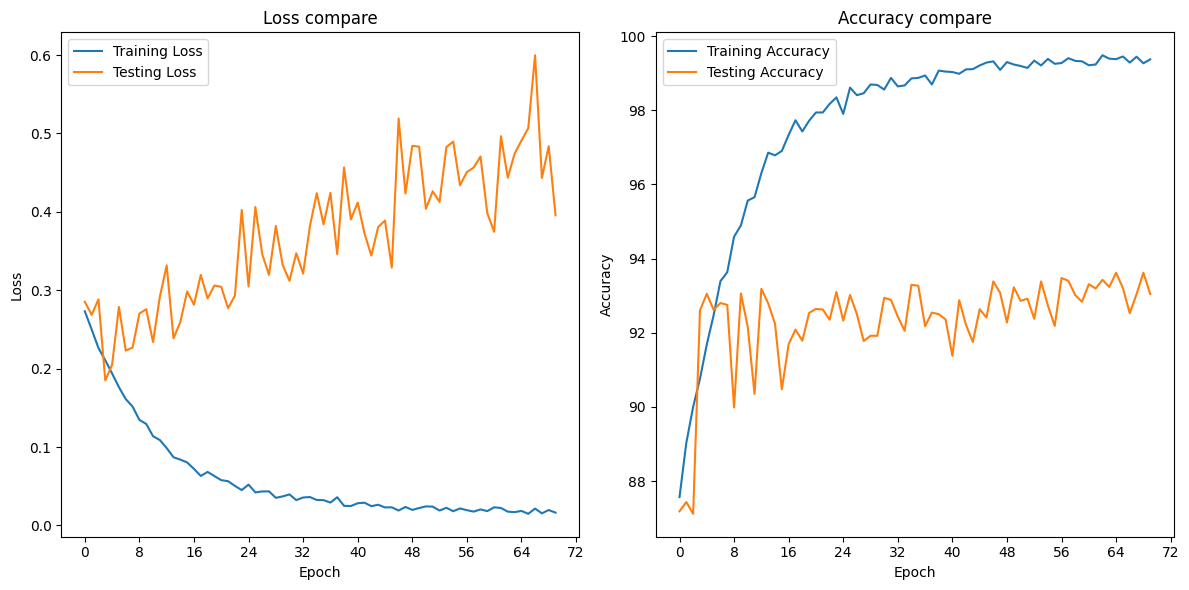

In [ ]:
import matplotlib.pyplot as plt
import json
from matplotlib.ticker import MaxNLocator



n_epochs = len(running_loss_list)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(np.arange(start, start+n_epochs,dtype=int), running_loss_list, label='Training Loss')
ax[0].plot(np.arange(start, start+n_epochs,dtype=int), testing_loss_list, label='Testing Loss')
ax[0].set_title('Loss compare')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))  # 設置 X 軸只顯示整數

ax[1].plot(np.arange(start, start+n_epochs,dtype=int), running_accu_list, label='Training Accuracy')
ax[1].plot(np.arange(start, start+n_epochs,dtype=int), testing_accu_list, label='Testing Accuracy')
ax[1].set_title('Accuracy compare')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))  # 設置 X 軸只顯示整數

plt.tight_layout()

figname = f'{os.path.dirname(savepath)}/{model_name}_loss.png'
if os.path.isfile(figname):
  print(f"{figname} exist.")
else:
  plt.savefig(figname)
plt.show()

lossname = f'{os.path.dirname(savepath)}/{model_name}_loss.json'


#若是從checkpoint跑模型,把loss data接上去,loss data預設在模型參數資料夾下
if os.path.isfile(lossname):
  with open(lossname, 'r') as f:
    data_to_save = json.load(f)
  data_to_save['running_loss_list'].extend(running_loss_list)
  data_to_save['testing_loss_list'].extend(testing_loss_list)
  data_to_save['running_accu_list'].extend(running_accu_list)
  data_to_save['testing_accu_list'].extend(testing_accu_list)
else:
  data_to_save = {
      'running_loss_list': running_loss_list,
      'testing_loss_list': testing_loss_list,
      'running_accu_list': running_accu_list,
      'testing_accu_list': testing_accu_list
  }

with open(lossname, 'w') as f:
    json.dump(data_to_save, f, indent=4)

# 儲存模型參數



In [ ]:
print(f'{model_name}_{epoch}')
print(f'{modeldirname}')

unet_without_decoder_81
unet_0.8_testintrain


In [ ]:

filename = save_model(model)


params = {
    'num_epochs': epoch,
    'batch_size': batch_size,
    'learning_rate': lr,
    'droprate': droprate
}

if os.path.isfile(filename+'.json'):
    print(f"{filename}.json exist.")
else:
    with open(f'{filename}.json', 'w') as f:
        json.dump(params, f)

model will be saved as /content/drive/MyDrive/AOCR2024/params//
請輸入模型儲存的檔名:unet_without_decoder_80
請輸入模型儲存的資料夾:unet_0.8_testintrain
/content/drive/MyDrive/AOCR2024/params/unet_0.8_testintrain/unet_without_decoder_80.pth exist.


# 讀取模型參數

In [43]:
model = pretrained_model
# model = unet_model
print(model_name)

efficientnet_b0


In [44]:
model = model.to(device)
model ,_ ,params, model_path = load_model(model)

請輸入模型參數檔案名稱:efficientnet_b0_70
請輸入儲存模型的母資料夾名稱:efficientnetv2_b0_ADAM_cosannealing
<All keys matched successfully>


# 單次評估


In [ ]:
# 評估設置
try:
  batch_size = params['batch_size']
except:
  batch_size = int(input("batch_size:"))
print(batch_size)


valid_dataset = CustomDataset(images_train, labels_train, transform=transform_standard)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
criterion = nn.BCELoss()
valid_loss, valid_accuracy, predict_list = valid(valid_loader, model, criterion, 0.5, device)

print(f"Accuracy of the network on the test images: {valid_accuracy}%")
print(f"Loss: {valid_loss}")
predict_listq = predict_list.cpu()


Accuracy of the network on the 15592   
training images: 99.20472036942022%  
Loss: 0.03187363331013983


In [ ]:
print_results(predict_listq, labels[:len(predict_listq)])

# 測試

In [21]:
testdir = "Cropped_60-316_150-406_11-71/Test_Image_cropped"

In [22]:
from google.auth.transport.requests import Request
request = Request()
credentials.refresh(request)
loop.run_until_complete(get_data_disk_async(drive_rootdir, testdir,token = credentials.token))

making Cropped_60-316_150-406_11-71/Test_Image_cropped dir...


100%|██████████| 200/200 [00:11<00:00, 18.06it/s]


In [23]:
images_test, info = read_test(testdir,termi=2,shift=0)

0: Read test ZxE0AE769C4E0DA3D095EF59A5158D7D0E0FB8881C1C87290D finished...
1: Read test Zx0CFEAEA49D4E19D1DB3BAE1248C9AE42D815CA7B52CC9E76 finished...
read 2 scans


In [24]:
len(images_test)

120

In [25]:
try:
  batch_size = params['batch_size']
except:
  batch_size = int(input("batch_size:"))
print(batch_size)


# 對testing dataset做normalization
# dataset = CustomDataset(images_test, None, mode='test', transform=transform_standard)
dataset = CustomDataset(images_test, None, mode='test', transform=None)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)


batch_size:16
16


In [45]:
model.eval()

predict_list = torch.tensor([]).to(device)
with torch.no_grad():  # 不更新梯度
    for j, batch_images in enumerate(dataloader):
        batch_images = batch_images.to(device)
        outputs = model(batch_images)
        predicted = (outputs.squeeze() > 0.5).int()

        # if predicted.dim() == 0:
        #   predicted = predicted.unsqueeze(0)
        predict_list = torch.cat((predict_list,predicted),0)


predict_listq = predict_list.cpu()

In [47]:
predict_listq.sum()

tensor(0.)

# 輸出至提交格式

images讀進來是疊在一起的。 需要info紀錄images檔名順序與分割情況

訓練過程不改變資料順序, 所以輸出順序同輸入.   
predict值跟隨images順序, 照著info把每個predict值(label)與檔名(id)對上. 輸出成提交格式

In [48]:
def yes(predict):
  return int(sum(predict) >= 3)



predict_list = predict_listq.numpy()

## 還原id與對應label，假設key按照scan輸入順序排列,每個key對應的scan的cuts數是nslice
output = {}
k = 0  #第幾個scan
ii = 0   #每個key輪到第幾個
id, nslice = info[k][0], info[k][1]
for i in range(len(predict_list)):

  if (ii >= nslice):
    #該換下一個scan了
    output[id] = yes(predict_list[i-nslice:i]) #評估方式

    k += 1
    ii = 0
    id, nslice = info[k][0], info[k][1]

  label = predict_list[i]
  output[id+f'_{ii}'] = int(predict_list[i])
  ii += 1

output[id] = yes(predict_list[(i+1)-ii:]) #補上最後一個scan評估
output = list(output.items())
dfout = pd.DataFrame(output)
dfout.columns = ['id', 'label']
dfout = dfout.sort_values(by='id', key=lambda x: x.map(custom_sort_key)) #把母label移動到子label前面
# filename = input("輸入提交路徑 (empty for submission\submission.csv)")
filename = "/content/tmp.csv"
dfout.to_csv(filename, index=False)

# 提交檔案後處理



## 把提交檔案(中間六十張)貼回sample_submission.csv

In [53]:


def update_id(id_string):
    # 分割 id 字符串，例如 'xxxxx_1' -> ['xxxxx', '1']

    if '_' in id_string:
        parts = id_string.split('_')
        new_number = int(parts[-1]) + 11
        return f"{parts[0]}_{new_number}"

    return id_string


# 使用正则表达式和刚定义的函数来更新'id'列
# 加载两个CSV文件
file_path_1 = os.path.join(drive_rootdir, 'sample_submission_2.csv')
file_path_2 = filename

data_1 = pd.read_csv(file_path_1)
data_2 = pd.read_csv(file_path_2)

# 母label遍0
data_2.loc[~data_2['id'].str.contains('_'), 'label'] = 0
data_2['id'] = data_2['id'].apply(update_id)
# 合并数据集，确保data_2中的label覆盖到data_1中相同ID的label
# 使用merge函数进行合并，并指定'how'和'on'参数
merged_data = pd.merge(data_1, data_2, on='id', how='left', suffixes=('', '_new'))

# 更新data_1的label列
merged_data['label'] = merged_data['label_new'].combine_first(merged_data['label'])

# 删除临时列
merged_data.drop(columns=['label_new'], inplace=True)

# 分割路径以提取所需部分
parts = model_path.split('/')

# 组合所需的部分
middlefile = f"{parts[-2]}_{parts[-1]}_answer.csv"


# 输出合并后的数据，或保存到新的CSV文件
merged_data.to_csv(middlefile, index=False)


## 母label與子label調整(all.py)，輸出至

In [55]:
import warnings
warnings.filterwarnings('ignore')


# 读取 CSV 文件
file_path = middlefile
df = pd.read_csv(file_path)

# 确保 id 列是字符串类型
df['id'] = df['id'].astype(str)

# 分割 id 来区分母序列和子序列
df['base_id'] = df['id'].str.extract(r'(.*?)(?:_\d+)?$')
df['is_mother'] = ~df['id'].str.contains('_')  # 母序列标记

# 连续1的数量阈值
continuous_one_threshold = 2

# 初始化母序列的 label 更新标志
df['update_mother_label'] = False

# 对每个母序列分组
for base_id, group in df.groupby('base_id'):
    # 只检查子序列
    sub_sequences = group[~group['is_mother']]

    # 检查是否有连续三个1
    consecutive_ones = 0
    for _, row in sub_sequences.iterrows():
        if row['label'] == 1:
            consecutive_ones += 1
            if consecutive_ones >= continuous_one_threshold:
                df.loc[(df['base_id'] == base_id) & (df['is_mother']), 'update_mother_label'] = True
                break
        else:
            consecutive_ones = 0

# 更改符合条件的母序列的 label
df.loc[df['update_mother_label'], 'label'] = 1
df.loc[~df['update_mother_label'] & df['is_mother'], 'label'] = 0

# 删除辅助列
df.drop(['base_id', 'is_mother', 'update_mother_label'], axis=1, inplace=True)

#确保 id 列是字符串类型
df['id'] = df['id'].astype(str)

# 分割 id 来区分母序列和子序列
df['base_id'] = df['id'].str.extract(r'(.*?)(?:_\d+)?$')

# 找到母序列的 label 为 0 的行
mother_ids_with_label_zero = df[(df['label'] == 0) & (~df['id'].str.contains('_'))]['base_id']

# 将所有对应子序列的 label 改为 0
for base_id in mother_ids_with_label_zero:
    df.loc[df['base_id'] == base_id, 'label'] = 0

# 删除辅助列
df.drop(['base_id'], axis=1, inplace=True)

# 确保 id 列是字符串类型
df['id'] = df['id'].astype(str)

# 创建一个标记是否为子序列的布尔列
df['is_subsequence'] = df['id'].str.contains('_')

# 添加一个用于存储周围0的计数的辅助列
df['zero_count'] = 0

# 定义检查周围0的数量的函数
def count_zeros_around(index, df, range_count):
    count = 0
    for i in range(index - range_count, index + range_count + 1):
        if i != index and 0 <= i < len(df) and df.at[i, 'label'] == 0:
            count += 1
    return count

# 更新 zero_count 列
range_count = 2  # 检查的前后范围
for index, row in df.iterrows():
    if row['is_subsequence'] and row['label'] == 1:
        df.at[index, 'zero_count'] = count_zeros_around(index, df, range_count)

# 定义需要的0的数量
zero_threshold = 3  # 您可以根据需要调整这个值

# 将满足条件的 label 改为 0
df.loc[df['zero_count'] >= zero_threshold, 'label'] = 0

# 删除辅助列
df.drop(['is_subsequence', 'zero_count'], axis=1, inplace=True)

# 保存修改后的数据到新的 CSV 文件

output_path = os.path.join(drive_rootdir, 'params', 'submission', middlefile)
df.to_csv(output_path, index=False)

# 初始化一个空的 DataFrame 用于存储结果
result_df = pd.DataFrame(columns=['id', 'label'])

# 遍历每个不同的ID（排除包含后缀的ID）
for unique_id in df['id'].str.extract(r'(.*?)(?:_\d+)?$')[0].unique():
    # 母序列
    mother_row = df[df['id'] == unique_id]
    if not mother_row.empty:
        result_df = pd.concat([result_df, mother_row])

    # 子序列
    child_rows = df[df['id'].str.contains(f'^{unique_id}_')]
    if not child_rows.empty:
        child_rows['suffix'] = child_rows['id'].str.extract(r'_(\d+)$').astype(int)
        min_suffix = child_rows[child_rows['label'] == 1]['suffix'].min()
        max_suffix = child_rows[child_rows['label'] == 1]['suffix'].max()

        # 更新子序列中的标签
        if pd.notna(min_suffix) and pd.notna(max_suffix):
            child_rows.loc[(child_rows['suffix'] >= min_suffix) & (child_rows['suffix'] <= max_suffix), 'label'] = 1

        result_df = pd.concat([result_df, child_rows.drop(columns=['suffix'])])

# 重置索引
result_df.reset_index(drop=True, inplace=True)

df=result_df

# 确保 id 列是字符串类型
df['id'] = df['id'].astype(str)

# 分割 id 来区分母序列和子序列
df['base_id'] = df['id'].str.extract(r'(.*?)(?:_\d+)?$')
df['is_mother'] = ~df['id'].str.contains('_')  # 母序列标记

# 连续1的数量阈值
continuous_one_threshold = 3

# 初始化母序列的 label 更新标志
df['update_mother_label'] = False

# 对每个母序列分组
for base_id, group in df.groupby('base_id'):
    # 只检查子序列
    sub_sequences = group[~group['is_mother']]

    # 检查是否有连续三个1
    consecutive_ones = 0
    for _, row in sub_sequences.iterrows():
        if row['label'] == 1:
            consecutive_ones += 1
            if consecutive_ones >= continuous_one_threshold:
                df.loc[(df['base_id'] == base_id) & (df['is_mother']), 'update_mother_label'] = True
                break
        else:
            consecutive_ones = 0

# 更改符合条件的母序列的 label
df.loc[df['update_mother_label'], 'label'] = 1
df.loc[~df['update_mother_label'] & df['is_mother'], 'label'] = 0

# 删除辅助列
df.drop(['base_id', 'is_mother', 'update_mother_label'], axis=1, inplace=True)

# 确保 id 列是字符串类型
df['id'] = df['id'].astype(str)

# 分割 id 来区分母序列和子序列
df['base_id'] = df['id'].str.extract(r'(.*?)(?:_\d+)?$')

# 找到母序列的 label 为 0 的行
mother_ids_with_label_zero = df[(df['label'] == 0) & (~df['id'].str.contains('_'))]['base_id']

# 将所有对应子序列的 label 改为 0
for base_id in mother_ids_with_label_zero:
    df.loc[df['base_id'] == base_id, 'label'] = 0

# 删除辅助列
df.drop(['base_id'], axis=1, inplace=True)

# 保存修改后的数据到新的 CSV 文件
output_path = os.path.join(drive_rootdir, 'params', 'submission', middlefile)
df.to_csv(output_path, index=False)

print(f"Modified data saved to {output_path}")




Modified data saved to /content/drive/MyDrive/AOCR2024/params/submission/efficientnetv2_b0_ADAM_cosannealing_efficientnet_b0_70_answer.csv


# 讀取提交格式的檔案

In [ ]:
dftest = read_submission('fisrt_80.csv')
# dftest = read_submission('submission.csv')
dflabel = read_label("TrainValid_ground_truth.csv")

In [ ]:
len(dftest)

In [ ]:
import re


# 抓出scan-level data
pattern = re.compile(r'.*_[0-9]+$')  # 正則表達式匹配 "_數字" 結尾
mask = ~dftest.index.str.match(pattern)
scan_guess = np.array(dftest[mask]['label'])
scan_truth = np.array(dflabel.loc[dftest[mask]['label'].index]['label'])

mask = ~mask
cut_guess = np.array(dftest[mask]['label'])
cut_truth = np.array(dflabel.loc[dftest[mask]['label'].index]['label'])

In [ ]:
ss = 10
print("="*ss + "F1 score on scan level" + "="*ss)
print_results(scan_guess, scan_truth)
print(),print()
print("="*ss + "F1 score on cut level" +"="*ss )
print_results(cut_guess, cut_truth)

# 其他指令
不在工作流
臨時使用

**驗證數據集標準化**

In [ ]:
from torch.utils.data import DataLoader
import torch

def calculate_mean_std(dataset):
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)

    # 初始化总和和平方总和变量，以及样本数量
    total_sum = 0.0
    total_sq_sum = 0.0
    total_count = 0

    for data in dataloader:
        images, _ = data  # 假设每个数据是 (image, label) 格式

        # 将图像数据移至CPU并转换为一维
        images = images.view(images.size(0), -1)
        total_sum += images.sum(dim=1).sum(dim=0)
        total_sq_sum += (images ** 2).sum(dim=1).sum(dim=0)
        total_count += images.size(0) * images.size(1)

    # 计算总平均值和标准差
    mean = total_sum / total_count
    std = (total_sq_sum / total_count - mean ** 2) ** 0.5

    return mean, std




In [ ]:
import torch
# 獲取數據
images, labels = process_data2(datadir, termi=100, dropFalse=0)

In [ ]:

# 計算原始圖片mean
original_mean = torch.mean(images)
original_std = torch.std(images)
print(f'Original Mean: {original_mean}')
print(f'Original Std: {original_std}')

# 製作數據集
transform = transforms.Normalize(mean=original_mean, std=original_std)
dataset = CustomDataset(images, labels , transform=transform)
normalized_mean, normalized_std = calculate_mean_std(dataset)


# 输出
print(f'Normalized Mean: {normalized_mean}')
print(f'Normalized Std: {normalized_std}')



# # 計算原始圖片mean
# original_mean = torch.mean(images)
# original_std = torch.std(images)
# print(f'Original Mean: {original_mean}')
# print(f'Original Std: {original_std}')

# # 製作數據集
# transform = transforms.Normalize(mean=original_mean, std=original_std)
# dataset = CustomDataset(images, labels)

# normalized_images, normalized_labels = dataset[:]
# normalized_mean, normalized_std = torch.mean(normalized_images), torch.std(normalized_images)


# print(f'Normalized Mean: {normalized_mean}')
# print(f'Normalized Std: {normalized_std}')


**下載每個checkpoint的參數並validate**

In [ ]:
filelist = os.listdir('/content/drive/MyDrive/AOCR2024/params/tf_efficiency_s/b128_0.8')
filelist = [f for f in filelist if '.pth' in f]
current_folder = r'tf_efficiency_s/b128_0.8'

In [ ]:
# model = unet_model
model = pretrained_model

model = model.to(device)
print(model_name)

criterion = nn.BCELoss()

tf_efficientnetv2_s


In [ ]:
train_id, valid_id = get_split()
images_valid, labels_valid = process_data2(datadir, dropFalse=0, files=valid_id)
images_validtrain, labels_validtrain =  process_data2(traindir=datadir,dropFalse=0,dropPos=0, files=train_id)

reading traindir='Cropped_60-316_150-406_11-71/Train_Valid_Image_cropped'...
xlim=[60, 316]
ylim=[150, 406]
zlim=[11, 71]
Process 0: Zx015DF8E20804DB94E24A9B2D9DD387A47EF1C620A02026DC finished...
Process 1: Zx01F90B532F87127DB647612B6621F2065CA58692B921CEB4 finished...
Process 2: Zx0494BD052F6F8D5A583699BBC329C318AC7B5BE50FD9ACDA finished...
Process 3: Zx0800DE5C96380322C65ABA398FC93B5CBDF75B20B11DDF6E finished...
Process 4: Zx09972B8FA6215EEC75DB4194B16C000F47B5F87AFB64A12B finished...
Process 5: Zx0A1564C092259CD377329E07006281E876D09F9B48E77002 finished...
Process 6: Zx0AE5424009C101F7422C5BD9DD2C3B0E13E834114A32883A finished...
Process 7: Zx0BA755CD6D068378215FE1AE4751945053ED5D2F2C2A40E7 finished...
Process 8: Zx0CA5CE197AA9378EE23F949BDFC91790D4FED5D6FD06F5A2 finished...
Process 9: Zx0CFB1637BD27964BE741B2AA07BC7C84B2B61731E47782E0 finished...
Process 10: Zx0E094D2402D05592511D0DED9E7ED9E999B468C249E9253F finished...
Process 11: Zx0E96DE51997AF17C5C54835EAD6B7512C66F91BFDB491B9F 

In [ ]:
batch_size = 128
mean_train_, std_train_ = torch.mean(images_validtrain), torch.std(images_validtrain)
transform_train_ = transforms.Normalize(mean=mean_train_, std=std_train_)
# validtrain_dataset = CustomDataset(images_validtrain, labels_validtrain, transform=transform_train_)
validtrain_dataset = CustomDataset(images_validtrain, labels_validtrain, transform=None)
validtrain_loader = DataLoader(validtrain_dataset, batch_size=batch_size, shuffle=True, drop_last=False)

# valid_dataset = CustomDataset(images_valid, labels_valid, mode='valid', transform=transform_train_)
valid_dataset = CustomDataset(images_valid, labels_valid, mode='valid', transform=None)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, drop_last=False)

running_loss_list = []
testing_loss_list = []
running_accu_list = []
testing_accu_list = []

for current_model in filelist[2:]:
  model,_,params,_ = load_model(model, modelname=current_model.rstrip('.pth'),dirname=current_folder)


  epoch_loss, epoch_accuracy, predict_list_validtrain, predict_labels_validtrain  = valid(validtrain_loader, model, criterion, 0.5, device)
  valid_loss, valid_accuracy, predict_list, predict_labels_valid = valid(valid_loader, model, criterion, 0.5, device)

  running_loss_list.append(epoch_loss)
  testing_loss_list.append(valid_loss)
  running_accu_list.append(epoch_accuracy)
  testing_accu_list.append(valid_accuracy)

  predict_listq = predict_list.cpu()
  predict_listq_validtrain = predict_list_validtrain.cpu()

  print(f"Accuracy of the {current_model} on the valid images: {valid_accuracy}%")
  print(f"Loss: {valid_loss}")
  print_results(predict_listq, predict_labels_valid)


  print(f"Accuracy of the {current_model} on the validtrain images: {epoch_accuracy}%")
  print(f"Loss: {epoch_loss}")
  print_results(predict_listq_validtrain, predict_labels_validtrain)

<All keys matched successfully>
Accuracy of the tf_efficientnetv2_s_50.pth on the valid images: 91.35833333333333%
Loss: 0.574329961566849

      真實值
  預  +-----+-----+
  測| TP: 295| FP: 423|
  值| FN: 614| TN: 10668|
      +-----+-----+ 

recall=0.32453245324532454
precision=0.41086350974930363
F1=0.36263060848186845

Accuracy of the tf_efficientnetv2_s_50.pth on the validtrain images: 99.07438292194797%
Loss: 0.026991445360006763

      真實值
  預  +-----+-----+
  測| TP: 3493| FP: 348|
  值| FN: 96| TN: 44031|
      +-----+-----+ 

recall=0.9732516021175815
precision=0.9093985941161156
F1=0.9402422611036338

<All keys matched successfully>
Accuracy of the tf_efficientnetv2_s_60.pth on the valid images: 91.125%
Loss: 0.5405721423473764

      真實值
  預  +-----+-----+
  測| TP: 436| FP: 592|
  值| FN: 473| TN: 10499|
      +-----+-----+ 

recall=0.47964796479647964
precision=0.42412451361867703
F1=0.45018069179143005

Accuracy of the tf_efficientnetv2_s_60.pth on the validtrain images: 99.21405

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import json
from matplotlib.ticker import MaxNLocator

savepath = "/content/drive/MyDrive/AOCR2024/params/tf_efficientnetv2_s_cos/tf_efficientnetv2_s_400"
n_epochs = len(running_loss_list)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot( running_loss_list, label='Training Loss')
ax[0].plot( testing_loss_list, label='Testing Loss')
ax[0].set_title('Loss compare')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))  # 設置 X 軸只顯示整數

ax[1].plot( running_accu_list, label='Training Accuracy')
ax[1].plot( testing_accu_list, label='Testing Accuracy')
ax[1].set_title('Accuracy compare')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))  # 設置 X 軸只顯示整數

plt.tight_layout()

figname = f'{os.path.dirname(savepath)}/{model_name}_loss.png'
if os.path.isfile(figname):
  print(f"{figname} exist.")
else:
  plt.savefig(figname)
plt.show()

lossname = f'{os.path.dirname(savepath)}/{model_name}_loss.json'


#若是從checkpoint跑模型,把loss data接上去,loss data預設在模型參數資料夾下
if os.path.isfile(lossname):
  with open(lossname, 'r') as f:
    data_to_save = json.load(f)
  data_to_save['running_loss_list'].extend(running_loss_list)
  data_to_save['testing_loss_list'].extend(testing_loss_list)
  data_to_save['running_accu_list'].extend(running_accu_list)
  data_to_save['testing_accu_list'].extend(testing_accu_list)
else:
  data_to_save = {
      'running_loss_list': running_loss_list,
      'testing_loss_list': testing_loss_list,
      'running_accu_list': running_accu_list,
      'testing_accu_list': testing_accu_list
  }

with open(lossname, 'w') as f:
    json.dump(data_to_save, f, indent=4)

drive檔案處理

重命名檔案

In [ ]:
cd /content/drive/MyDrive/AOCR2024/params

In [ ]:
# %shell for file in tf_efficientnetv2_m*; do mv "$file" "${file/tf_efficientnetv2_m/unet}"; done

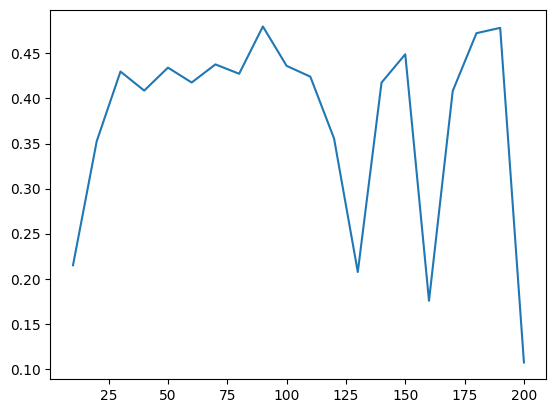

In [ ]:
import matplotlib.pyplot as plt

x = range(10,210,10)
y = [0.21497405485544846,0.3526900085397096,0.42987249544626593,0.408731241473397,0.43421052631578944,0.41770102536427417,0.43779342723004694,0.42740414833438095,0.47986434930055116,0.4362030905077262,0.4241719930273096,0.3555230431602049,0.20746132848043677,0.4176013805004314,0.4490445859872611,0.17557251908396945,0.40830945558739257,0.472430224642614,0.47833775419982316,0.1071060762100927]
plt.plot(x,y)